In [1]:
import numpy as np
from tensorflow.keras import utils as np_utils
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
print( tf.__version__ )
print( tf.config.list_physical_devices() )

2.9.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = to_categorical(y, 3)
    return x, y

In [3]:
'''
Data is the FI-2010 Data
https://arxiv.org/abs/1705.03233
'''

# please change the data_path to your local path
data_path = 'data/'

dec_data = np.loadtxt(data_path + 'Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data#[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt(data_path + 'Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt(data_path + 'Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt(data_path + 'Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

k = 4 # which prediction horizon
T = 100 # the length of a single input
checkpoint_filepath = './model_tensorflow2/weights'

trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)

print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)


(254651, 100, 40, 1) (254651, 3)
(50851, 100, 40, 1) (50851, 3)
(139488, 100, 40, 1) (139488, 3)


In [4]:
'''
New (Optional) Data Augmentation Proceedure
'''

def get_image_data(cnn_data):
    new_x = cnn_data.copy()
    for j in range(new_x.shape[0]):
        x_coords = np.arange(
            np.min(new_x[j,:,::2,0]), 
            np.max(new_x[j,:,::2,0]), 
            np.min( np.abs( np.diff( new_x[j,0,::4,0] ) ) ) #ticksize
        )
        new_image = np.zeros((100,len(x_coords)+1))
        
        for z in range(100):
            new_image[z, np.digitize( new_x[j,z,2::4,0], x_coords )] = new_x[j,z,3::4,0] #bid prices
            new_image[z, np.digitize( new_x[j,z,::4,0], x_coords )] = -new_x[j,z,1::4,0] #ask prices

        anchor_position = np.digitize( new_x[j,-1,2,0], x_coords )
        while anchor_position < 20:
            new_image = np.hstack([np.zeros((100,1)),new_image])
            anchor_position += 1

        while new_image.shape[1] < anchor_position+20:
            new_image = np.hstack([new_image,np.zeros((100,1))])
            
        new_x[j,:,:,0] = new_image[:,range(anchor_position-20,anchor_position+20)]
        if j % 100 == 0:
            print( j, end="\r")
    return new_x
    
new_x_train = get_image_data(trainX_CNN)
new_x_val = get_image_data(valX_CNN)
new_x_test = get_image_data(testX_CNN)

In [5]:
'''
Create the Translob
'''

from translob_files.LobFeatures import *
from translob_files.LobPosition import *
from translob_files.LobTransformer import *

def create_translob(T,NF):
    input_lmd = tf.keras.layers.Input(shape=(T, NF))
    y = lob_dilated(input_lmd)
    y = tf.keras.layers.LayerNormalization(axis=1)( y )
    y = positional_encoding( y )
    y = TransformerBlock('t_block1', 3)(y)
    y = TransformerBlock('t_block2', 3)(y)
#     y = TransformerBlock('t_block3', 3)(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer='l2')(y)
    y = tf.keras.layers.Dropout( 0.1 )(y)
    out = tf.keras.layers.Dense(3,activation="softmax")(y)
    model = tf.keras.Model(inputs=input_lmd, outputs=out)
    adam = tf.keras.optimizers.Adam(lr=0.0001)#, beta_1=0.9, beta_2=0.999, epsilon=1)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

translob = create_translob(100, 40)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="weights_translob",
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True
)

/home/jefferythewind/anaconda3/envs/ml/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
'''
Train
'''

history = translob.fit(
    trainX_CNN[:,:,:,0],
    trainY_CNN, 
    epochs=200, 
    batch_size=128, 
    verbose=2, 
    validation_data=(
        valX_CNN[:,:,:,0],
        valY_CNN
    ),
    callbacks=[model_checkpoint_callback]

)

Epoch 1/200
1990/1990 - 19s - loss: 1.4241 - accuracy: 0.4054 - val_loss: 1.1741 - val_accuracy: 0.3723 - 19s/epoch - 10ms/step
Epoch 2/200
1990/1990 - 15s - loss: 1.0680 - accuracy: 0.4081 - val_loss: 1.0988 - val_accuracy: 0.3637 - 15s/epoch - 8ms/step
Epoch 3/200
1990/1990 - 16s - loss: 1.0323 - accuracy: 0.4135 - val_loss: 1.0921 - val_accuracy: 0.3728 - 16s/epoch - 8ms/step
Epoch 4/200
1990/1990 - 16s - loss: 1.0146 - accuracy: 0.4282 - val_loss: 1.0869 - val_accuracy: 0.3748 - 16s/epoch - 8ms/step
Epoch 5/200
1990/1990 - 16s - loss: 0.9865 - accuracy: 0.4513 - val_loss: 1.0335 - val_accuracy: 0.4293 - 16s/epoch - 8ms/step
Epoch 6/200
1990/1990 - 15s - loss: 0.9653 - accuracy: 0.4726 - val_loss: 1.0271 - val_accuracy: 0.4398 - 15s/epoch - 8ms/step
Epoch 7/200
1990/1990 - 16s - loss: 0.9539 - accuracy: 0.4877 - val_loss: 1.0127 - val_accuracy: 0.4714 - 16s/epoch - 8ms/step
Epoch 8/200
1990/1990 - 15s - loss: 0.9455 - accuracy: 0.4988 - val_loss: 1.0050 - val_accuracy: 0.4831 - 15s/

1990/1990 - 15s - loss: 0.3103 - accuracy: 0.8965 - val_loss: 0.2783 - val_accuracy: 0.9044 - 15s/epoch - 8ms/step
Epoch 71/200
1990/1990 - 16s - loss: 0.3044 - accuracy: 0.8983 - val_loss: 0.2683 - val_accuracy: 0.9089 - 16s/epoch - 8ms/step
Epoch 72/200
1990/1990 - 16s - loss: 0.3010 - accuracy: 0.9000 - val_loss: 0.2643 - val_accuracy: 0.9105 - 16s/epoch - 8ms/step
Epoch 73/200
1990/1990 - 16s - loss: 0.2965 - accuracy: 0.9021 - val_loss: 0.2575 - val_accuracy: 0.9133 - 16s/epoch - 8ms/step
Epoch 74/200
1990/1990 - 16s - loss: 0.2935 - accuracy: 0.9026 - val_loss: 0.2678 - val_accuracy: 0.9083 - 16s/epoch - 8ms/step
Epoch 75/200
1990/1990 - 16s - loss: 0.2896 - accuracy: 0.9048 - val_loss: 0.2579 - val_accuracy: 0.9132 - 16s/epoch - 8ms/step
Epoch 76/200
1990/1990 - 16s - loss: 0.2872 - accuracy: 0.9052 - val_loss: 0.2570 - val_accuracy: 0.9129 - 16s/epoch - 8ms/step
Epoch 77/200
1990/1990 - 16s - loss: 0.2868 - accuracy: 0.9053 - val_loss: 0.2524 - val_accuracy: 0.9151 - 16s/epoch 

Epoch 134/200
1990/1990 - 15s - loss: 0.2335 - accuracy: 0.9226 - val_loss: 0.2133 - val_accuracy: 0.9264 - 15s/epoch - 8ms/step
Epoch 135/200
1990/1990 - 16s - loss: 0.2339 - accuracy: 0.9222 - val_loss: 0.2171 - val_accuracy: 0.9243 - 16s/epoch - 8ms/step
Epoch 136/200
1990/1990 - 16s - loss: 0.2342 - accuracy: 0.9220 - val_loss: 0.2139 - val_accuracy: 0.9260 - 16s/epoch - 8ms/step
Epoch 137/200
1990/1990 - 16s - loss: 0.2328 - accuracy: 0.9226 - val_loss: 0.2167 - val_accuracy: 0.9255 - 16s/epoch - 8ms/step
Epoch 138/200
1990/1990 - 16s - loss: 0.2329 - accuracy: 0.9222 - val_loss: 0.2143 - val_accuracy: 0.9246 - 16s/epoch - 8ms/step
Epoch 139/200
1990/1990 - 16s - loss: 0.2325 - accuracy: 0.9225 - val_loss: 0.2116 - val_accuracy: 0.9261 - 16s/epoch - 8ms/step
Epoch 140/200
1990/1990 - 15s - loss: 0.2324 - accuracy: 0.9223 - val_loss: 0.2155 - val_accuracy: 0.9253 - 15s/epoch - 8ms/step
Epoch 141/200
1990/1990 - 15s - loss: 0.2323 - accuracy: 0.9227 - val_loss: 0.2137 - val_accuracy

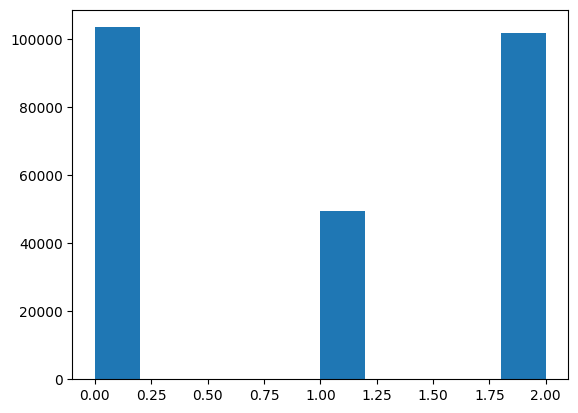

In [7]:
'''Check Label Balance'''

import matplotlib.pyplot as plt
plt.hist( np.argmax( trainY_CNN, axis=1 ) )
plt.show()

In [8]:
'''
Load Best Weights
'''

translob.load_weights("weights_translob")
pred = translob.predict(testX_CNN)

4359/4359 [==============================] - 11s 2ms/step


In [9]:
'''
Check OOS Performance

'''


from sklearn.metrics import classification_report, accuracy_score
translob.load_weights("weights_translob")
pred = translob.predict(testX_CNN)
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

4359/4359 [==============================] - 10s 2ms/step
accuracy_score: 0.9251548520302821
              precision    recall  f1-score   support

           0     0.9296    0.9344    0.9320     47915
           1     0.9124    0.9188    0.9156     48050
           2     0.9346    0.9219    0.9282     43523

    accuracy                         0.9252    139488
   macro avg     0.9255    0.9251    0.9253    139488
weighted avg     0.9252    0.9252    0.9252    139488



In [10]:
'''
Now same proceedure w/ Augmented Data

'''


translob2 = create_translob(100, 40)

model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath="weights_translob2",
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True
)

history2 = translob2.fit(
    new_x_train[:,:,:,0],
    trainY_CNN, 
    
    epochs=200, 
    batch_size=128, 
    verbose=2, 
    validation_data=(
        new_x_val[:,:,:,0],
        valY_CNN
    ),
    callbacks=[model_checkpoint_callback2]

)

/home/jefferythewind/anaconda3/envs/ml/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
1990/1990 - 19s - loss: 1.4066 - accuracy: 0.5677 - val_loss: 1.0901 - val_accuracy: 0.5830 - 19s/epoch - 9ms/step
Epoch 2/200
1990/1990 - 16s - loss: 0.8863 - accuracy: 0.6690 - val_loss: 0.8247 - val_accuracy: 0.6746 - 16s/epoch - 8ms/step
Epoch 3/200
1990/1990 - 16s - loss: 0.7340 - accuracy: 0.7181 - val_loss: 0.7370 - val_accuracy: 0.7115 - 16s/epoch - 8ms/step
Epoch 4/200
1990/1990 - 16s - loss: 0.6758 - accuracy: 0.7363 - val_loss: 0.6925 - val_accuracy: 0.7258 - 16s/epoch - 8ms/step
Epoch 5/200
1990/1990 - 16s - loss: 0.6407 - accuracy: 0.7490 - val_loss: 0.6564 - val_accuracy: 0.7411 - 16s/epoch - 8ms/step
Epoch 6/200
1990/1990 - 16s - loss: 0.6175 - accuracy: 0.7584 - val_loss: 0.6353 - val_accuracy: 0.7531 - 16s/epoch - 8ms/step
Epoch 7/200
1990/1990 - 16s - loss: 0.5986 - accuracy: 0.7674 - val_loss: 0.6249 - val_accuracy: 0.7595 - 16s/epoch - 8ms/step
Epoch 8/200
1990/1990 - 16s - loss: 0.5849 - accuracy: 0.7737 - val_loss: 0.5956 - val_accuracy: 0.7728 - 16s/e

1990/1990 - 16s - loss: 0.3900 - accuracy: 0.8622 - val_loss: 0.4221 - val_accuracy: 0.8487 - 16s/epoch - 8ms/step
Epoch 66/200
1990/1990 - 16s - loss: 0.3882 - accuracy: 0.8631 - val_loss: 0.4159 - val_accuracy: 0.8506 - 16s/epoch - 8ms/step
Epoch 67/200
1990/1990 - 16s - loss: 0.3866 - accuracy: 0.8639 - val_loss: 0.4260 - val_accuracy: 0.8467 - 16s/epoch - 8ms/step
Epoch 68/200
1990/1990 - 16s - loss: 0.3847 - accuracy: 0.8652 - val_loss: 0.4295 - val_accuracy: 0.8442 - 16s/epoch - 8ms/step
Epoch 69/200
1990/1990 - 16s - loss: 0.3830 - accuracy: 0.8662 - val_loss: 0.4247 - val_accuracy: 0.8467 - 16s/epoch - 8ms/step
Epoch 70/200
1990/1990 - 16s - loss: 0.3823 - accuracy: 0.8656 - val_loss: 0.4161 - val_accuracy: 0.8501 - 16s/epoch - 8ms/step
Epoch 71/200
1990/1990 - 16s - loss: 0.3812 - accuracy: 0.8667 - val_loss: 0.4108 - val_accuracy: 0.8537 - 16s/epoch - 8ms/step
Epoch 72/200
1990/1990 - 16s - loss: 0.3789 - accuracy: 0.8674 - val_loss: 0.4109 - val_accuracy: 0.8526 - 16s/epoch 

Epoch 129/200
1990/1990 - 16s - loss: 0.3277 - accuracy: 0.8891 - val_loss: 0.3730 - val_accuracy: 0.8700 - 16s/epoch - 8ms/step
Epoch 130/200
1990/1990 - 16s - loss: 0.3271 - accuracy: 0.8892 - val_loss: 0.3733 - val_accuracy: 0.8702 - 16s/epoch - 8ms/step
Epoch 131/200
1990/1990 - 16s - loss: 0.3271 - accuracy: 0.8893 - val_loss: 0.3616 - val_accuracy: 0.8767 - 16s/epoch - 8ms/step
Epoch 132/200
1990/1990 - 16s - loss: 0.3263 - accuracy: 0.8905 - val_loss: 0.3722 - val_accuracy: 0.8705 - 16s/epoch - 8ms/step
Epoch 133/200
1990/1990 - 16s - loss: 0.3250 - accuracy: 0.8908 - val_loss: 0.3677 - val_accuracy: 0.8712 - 16s/epoch - 8ms/step
Epoch 134/200
1990/1990 - 16s - loss: 0.3254 - accuracy: 0.8903 - val_loss: 0.3701 - val_accuracy: 0.8713 - 16s/epoch - 8ms/step
Epoch 135/200
1990/1990 - 16s - loss: 0.3248 - accuracy: 0.8903 - val_loss: 0.3594 - val_accuracy: 0.8761 - 16s/epoch - 8ms/step
Epoch 136/200
1990/1990 - 16s - loss: 0.3249 - accuracy: 0.8905 - val_loss: 0.3615 - val_accuracy

Epoch 193/200
1990/1990 - 16s - loss: 0.3006 - accuracy: 0.9004 - val_loss: 0.3394 - val_accuracy: 0.8851 - 16s/epoch - 8ms/step
Epoch 194/200
1990/1990 - 16s - loss: 0.3009 - accuracy: 0.9005 - val_loss: 0.3430 - val_accuracy: 0.8828 - 16s/epoch - 8ms/step
Epoch 195/200
1990/1990 - 16s - loss: 0.3002 - accuracy: 0.9003 - val_loss: 0.3452 - val_accuracy: 0.8799 - 16s/epoch - 8ms/step
Epoch 196/200
1990/1990 - 16s - loss: 0.3003 - accuracy: 0.9004 - val_loss: 0.3459 - val_accuracy: 0.8812 - 16s/epoch - 8ms/step
Epoch 197/200
1990/1990 - 16s - loss: 0.3000 - accuracy: 0.9001 - val_loss: 0.3455 - val_accuracy: 0.8799 - 16s/epoch - 8ms/step
Epoch 198/200
1990/1990 - 16s - loss: 0.2991 - accuracy: 0.9006 - val_loss: 0.3341 - val_accuracy: 0.8847 - 16s/epoch - 8ms/step
Epoch 199/200
1990/1990 - 16s - loss: 0.2990 - accuracy: 0.9011 - val_loss: 0.3319 - val_accuracy: 0.8870 - 16s/epoch - 8ms/step
Epoch 200/200
1990/1990 - 16s - loss: 0.2991 - accuracy: 0.9010 - val_loss: 0.3426 - val_accuracy

In [11]:
translob2.load_weights("weights_translob2")
pred2 = translob2.predict(new_x_test)

4359/4359 [==============================] - 11s 2ms/step


In [12]:
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred2, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred2, axis=1), digits=4))

accuracy_score: 0.8531916724019271
              precision    recall  f1-score   support

           0     0.8485    0.8813    0.8646     47915
           1     0.8656    0.8165    0.8404     48050
           2     0.8457    0.8627    0.8541     43523

    accuracy                         0.8532    139488
   macro avg     0.8533    0.8535    0.8530    139488
weighted avg     0.8535    0.8532    0.8530    139488



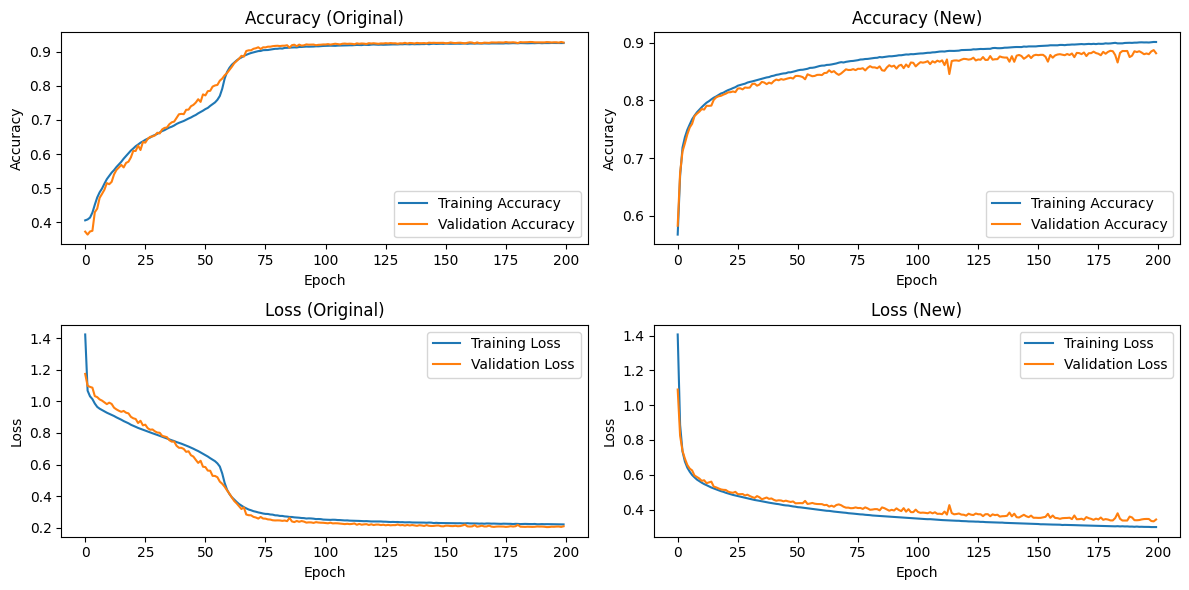

In [13]:
import matplotlib.pyplot as plt

# Create a figure with a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# History 1 (Left) - Training Accuracy and Validation Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy (Original)')
axes[0, 0].legend()

# History 2 (Right) - Training Accuracy and Validation Accuracy
axes[0, 1].plot(history2.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history2.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy (New)')
axes[0, 1].legend()

# History 1 (Left) - Training Loss and Validation Loss
axes[1, 0].plot(history.history['loss'], label='Training Loss')
axes[1, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Loss (Original)')
axes[1, 0].legend()

# History 2 (Right) - Training Loss and Validation Loss
axes[1, 1].plot(history2.history['loss'], label='Training Loss')
axes[1, 1].plot(history2.history['val_loss'], label='Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Loss (New)')
axes[1, 1].legend()

# Adjust subplot layout
plt.tight_layout()
plt.savefig('translob_training_stats.png')
# Show the plot
plt.show()


In [14]:
'''
Prediction Horizon
Horizon  Original, New
0 78 85
1 70 73
2 75 78
3 87 82.5
4 93 85





'''

'\nPrediction Horizon\nHorizon  Original, New\n0 78 85\n1 69.5 73.4\n2 75 78\n3 87 82.5\n4 \n\n\n\n\n\n'